## Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings("ignore")
import random

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

Creating a function to read information from the txt file in the directory

In [3]:
def get_info(columns: str|list = "all"):
    with open("VariableDefinitions.txt", "r")as f:
        lines = f.readlines()
        count = 0
        if columns == "all":
            for line in lines:
                if line.lstrip() == line:
                    print(line.strip())
                    count += 1
        elif type(columns) == str:
            for line in lines:
                header, _ = line.split(" - ")
                if columns == header:
                    print(line.strip())
                    count += 1
        elif type(columns) == list:
            for column in columns:
                for line in lines:
                    header, _ = line.split(" - ")
                    if column == header:
                        print(line.strip())
                        count += 1
        if count == 0:
            print("No information found.")

In [4]:
get_info()

10u - Zonal wind component at 10 meters above the surface (east-west direction)
10v - Meridional wind component at 10 meters above the surface (north-south direction)
2d - Dew point temperature at 2 meters above the surface
2t - Air temperature at 2 meters above the surface
evabs - Evaporation from bare soil
evaow - Evaporation from open water
evatc - Total column evaporation
evavt - Evapotranspiration (combined evaporation and plant transpiration)
albedo - Surface albedo (reflectivity of the surface)
lshf - Latent heat flux (energy transfer due to evaporation and condensation)
lai_hv - Leaf Area Index for high vegetation
lai_lv - Leaf Area Index for low vegetation
pev - Potential evaporation
ro - Runoff (water that flows over the land surface)
src - Surface runoff coefficient
skt - Skin temperature (temperature of the Earth's surface)
es - Surface evapotranspiration
stl1 - Soil temperature in the top soil layer
stl2 - Soil temperature in the second soil layer
stl3 - Soil temperature i

## Reading and previewing the data

In [5]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
toilets = pd.read_csv("toilets.csv")
waste = pd.read_csv("waste_management.csv")
water = pd.read_csv("water_sources.csv")

In [6]:
waste.drop_duplicates(inplace=True)

In [7]:
train.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267


In [8]:
water.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,...,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.57424,68.23761,1_2019,-8.57424_68.23761,1_2019_-8.57424_68.23761
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,...,0.003201,0.254517,0.259918,0.281769,0.296188,-8.57424,68.23761,2_2019,-8.57424_68.23761,2_2019_-8.57424_68.23761
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,...,0.004682,0.278152,0.284195,0.261597,0.291672,-8.57424,68.23761,3_2019,-8.57424_68.23761,3_2019_-8.57424_68.23761
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,...,0.007518,0.385513,0.378616,0.309784,0.288925,-8.57424,68.23761,4_2019,-8.57424_68.23761,4_2019_-8.57424_68.23761
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,...,0.005989,0.397659,0.400055,0.392654,0.309311,-8.57424,68.23761,5_2019,-8.57424_68.23761,5_2019_-8.57424_68.23761


In [9]:
waste.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,...,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.58518,68.25058,1_2019,-8.58518_68.25058,1_2019_-8.58518_68.25058
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,...,0.003201,0.254517,0.259918,0.281769,0.296188,-8.58518,68.25058,2_2019,-8.58518_68.25058,2_2019_-8.58518_68.25058
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,...,0.004682,0.278152,0.284195,0.261597,0.291672,-8.58518,68.25058,3_2019,-8.58518_68.25058,3_2019_-8.58518_68.25058
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,...,0.007518,0.385513,0.378616,0.309784,0.288925,-8.58518,68.25058,4_2019,-8.58518_68.25058,4_2019_-8.58518_68.25058
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,...,0.005989,0.397659,0.400055,0.392654,0.309311,-8.58518,68.25058,5_2019,-8.58518_68.25058,5_2019_-8.58518_68.25058


In [10]:
toilets.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,...,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,...,0.003201,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,...,0.004682,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,...,0.007518,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,...,0.005989,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536


## Exploratory Data Analysis and Data Cleaning

In [11]:
train.isna().sum()

ID                               0
Total                            1
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

Filling the one empty spot in the train dataset with the mean

In [12]:
train["Total"] = train["Total"].fillna(train["Total"].mean())

There's no empty data in the test dataset

In [13]:
test.isna().sum()

Location                         0
Disease                          0
Month                            0
Category_Health_Facility_UUID    0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
ID                               0
dtype: int64

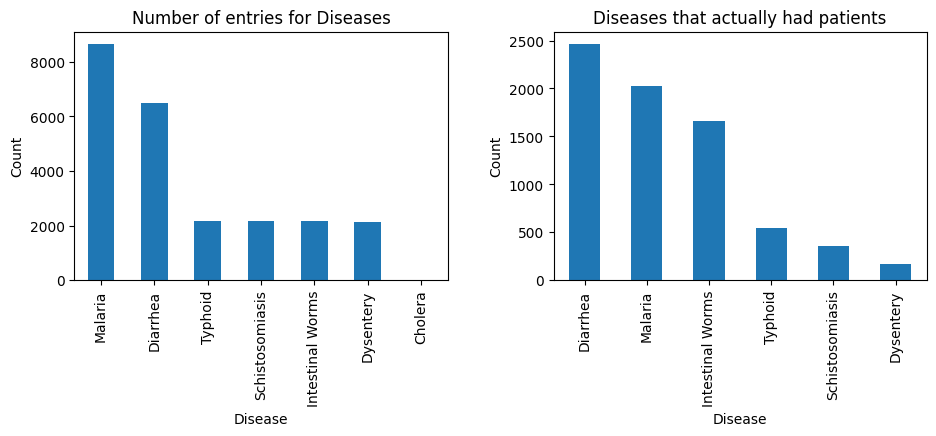

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train.Disease.value_counts().plot(kind="bar")
plt.title("Number of entries for Diseases")
plt.ylabel("Count")
plt.xlabel("Disease")

plt.subplot(1, 2, 2)
train[train.Total > 0].Disease.value_counts().plot(kind="bar")
plt.title("Diseases that actually had patients")
plt.ylabel("Count")
plt.xlabel("Disease")
plt.tight_layout(pad=3)
plt.show()

According to the graph some inferences could be made:
* People who had `cholera` may have not gone to hospitals to get themselves checked or there were actually no cases of `cholera`.
* More hospitals checked for `malaria` than for other diseases but the disease with the most patients is `Diarrhea`.
* This could mean that the hospitals have done a good job in battling `malaria` since that has more entries than other diseases.
* It could also mean that `malaria` is more common than other diseases.
* Could also mean `malaria` has similar symptoms to the other diseases so each case is checked more frequently in anticipation of it being `malaria`.

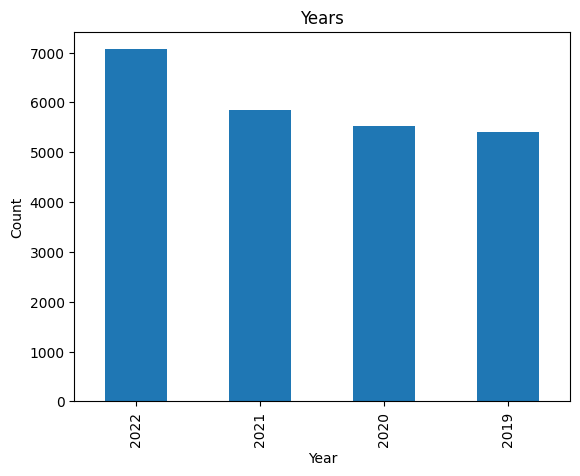

In [15]:
train.Year.value_counts().plot(kind="bar")
plt.title("Years")
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()

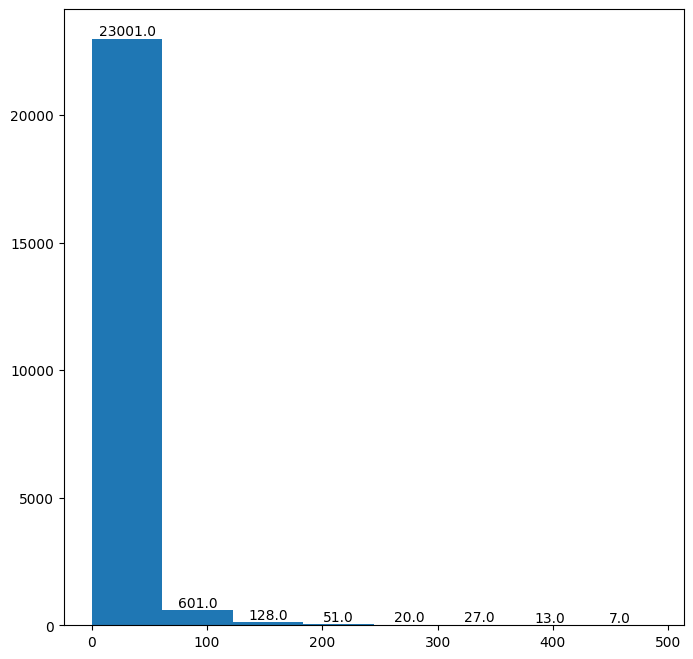

In [16]:
plt.figure(figsize=(8, 8))
ax = plt.hist(train.Total, bins=8)
for item in ax[2].patches:
    value = item.get_height()
    plt.text(item.get_x() + item.get_width() / 2, value + 1, round(value, 2), ha='center', va='bottom')
plt.show()


This means most hospitals had smaller number of cases.

In [17]:
cases = ["Yes" if x > 0 else "No" for x in train.Total]
cases = pd.Series(cases)

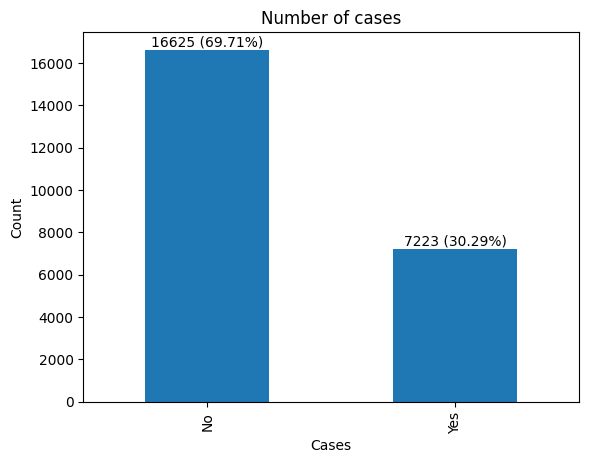

In [18]:
ax = cases.value_counts().plot(kind="bar")
for item in ax.patches:
    value = item.get_height()
    ax.text(item.get_x() + item.get_width() / 2, value + 1, f"{value} ({round(value / len(cases) * 100, 2)}%)", ha='center', va='bottom')
plt.title("Number of cases")
plt.xlabel("Cases")
plt.ylabel("Count")
plt.show()

There was more of no cases than there was of cases. This means more of the residents are healthy from the diseases in this dataset.

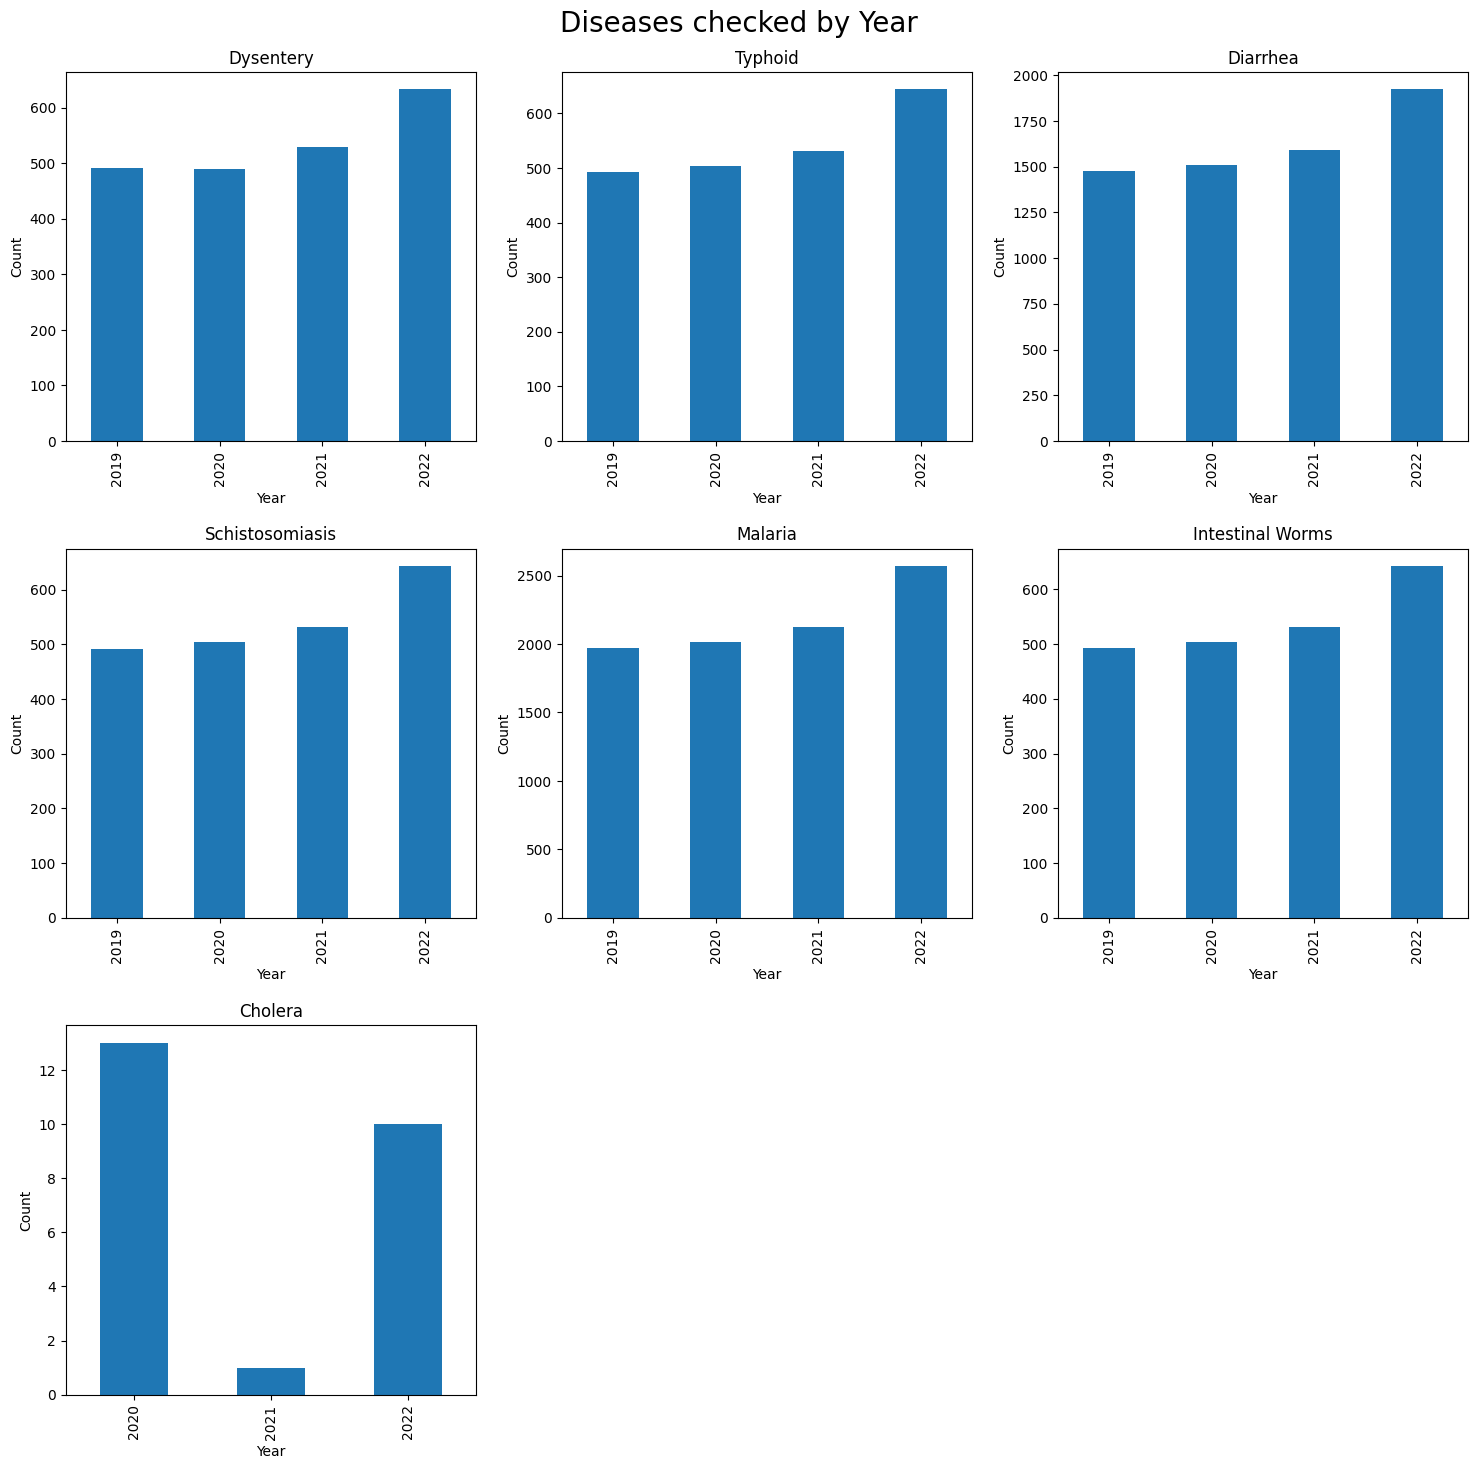

In [19]:
plt.figure(figsize=(15, 15))
for i, disease in enumerate(train.Disease.unique()):
    plt.subplot(3, 3, i + 1)
    train[train.Disease == disease].Year.value_counts().sort_index().plot(kind="bar")
    plt.title(disease)
    plt.ylabel("Count")
    plt.xlabel("Year")
plt.suptitle("Diseases checked by Year", fontsize=20)
plt.tight_layout(pad=1.5)
plt.show()

From this chart, it can be noticed that the awareness of the hospitals for each of the diseases are increasing.

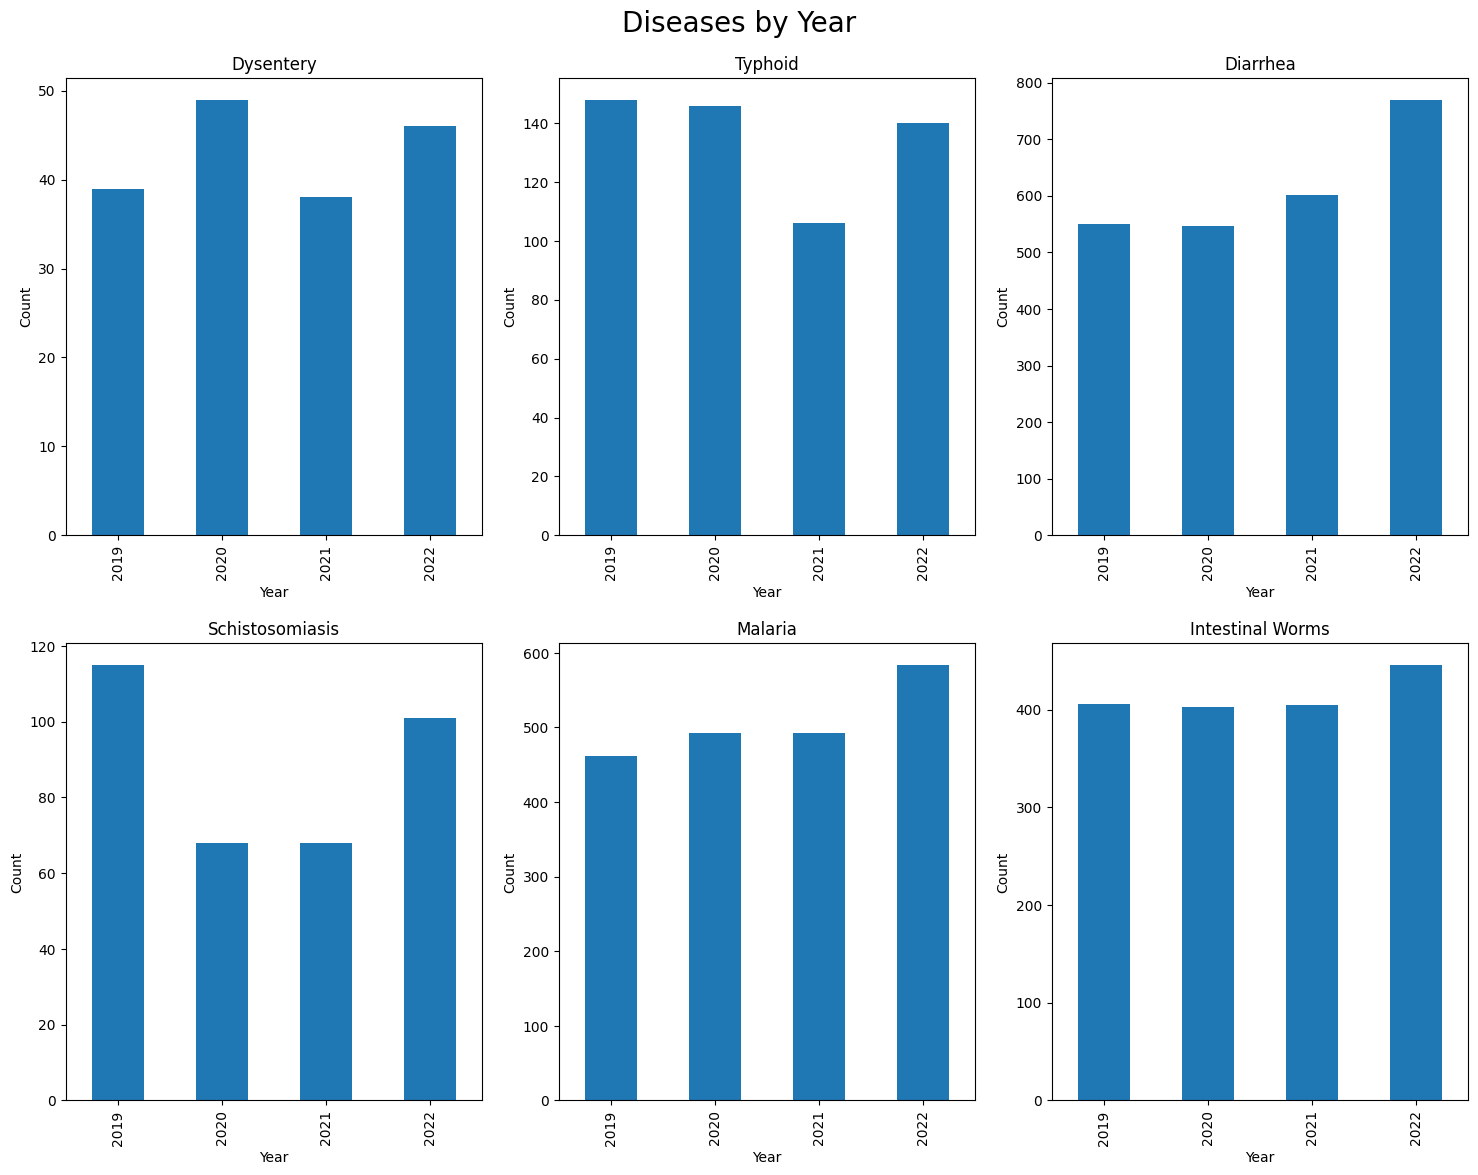

In [20]:
plt.figure(figsize=(15, 12))
for i, disease in enumerate(train.Disease.unique()):
    if disease == "Cholera":
        continue
    plt.subplot(2, 3, i + 1)
    train[(train.Disease == disease) & (train.Total > 0)].Year.value_counts().sort_index().plot(kind="bar")
    plt.title(disease)
    plt.ylabel("Count")
    plt.xlabel("Year")
plt.suptitle("Diseases by Year", fontsize=20)
plt.tight_layout(pad=1.5)
plt.show()

Inference:
* `Diarrhea` and `malaria` have been getting worse as the time goes by.


#### Dealing with `water_sources`, `toilets` and `waste` tables

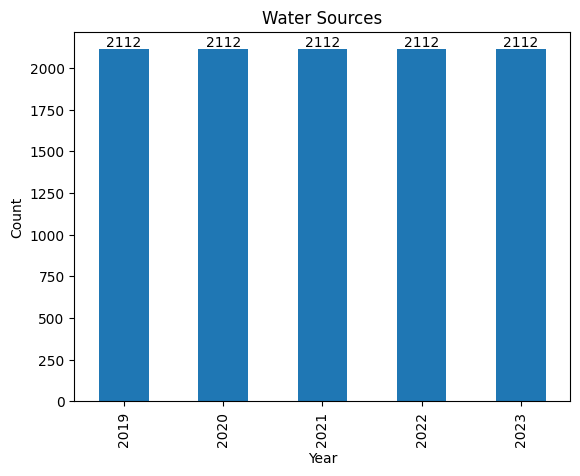

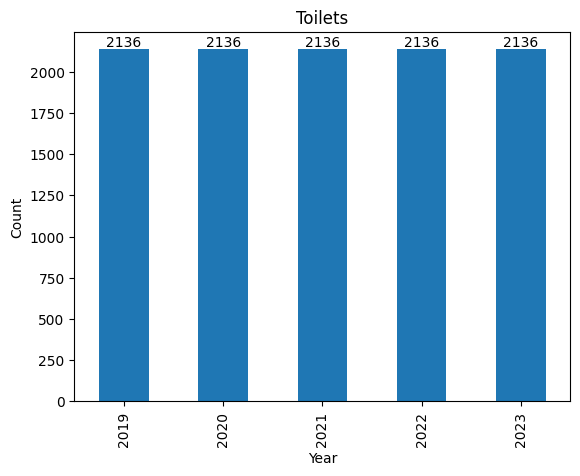

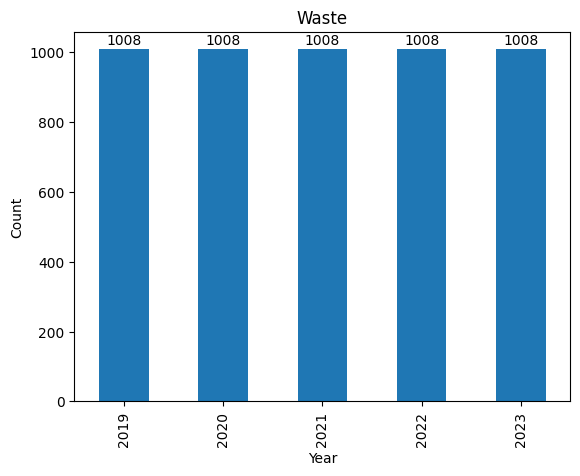

In [21]:
data = [
    (water, "Water Sources"),
    (toilets, "Toilets"),
    (waste, "Waste")
]

for df, name in data:
    ax = df.Year.value_counts().sort_index().plot(kind="bar")
    for item in ax.patches:
        value = item.get_height()
        ax.text(item.get_x() + item.get_width() / 2, value + 15, value, ha="center")
    plt.title(name)
    plt.ylabel("Count")
    plt.xlabel("Year")
    plt.show()

For the cases of the waste, toilet and water dataframes, the number of entries for each year are equal

In [22]:
def empty(df, name):
    print(f"{name} table has {int(df.isnull().any().sum())} number of columns with empty values")

empty(water, "Water Sources")
empty(toilets, "Toilets")
empty(waste, "Waste")

Water Sources table has 2 number of columns with empty values
Toilets table has 0 number of columns with empty values
Waste table has 0 number of columns with empty values


In [23]:
print("Percentage of missing values in the Water Sources table")
water.isnull().sum()[water.isnull().sum()>0] / len(water) * 100

Percentage of missing values in the Water Sources table


Transformed_Latitude     0.568182
Transformed_Longitude    0.568182
dtype: float64

The data missing is less than 1percent of the whole dataset so it can be dropped from the dataset as part of the data cleaning process.

In [24]:
previous = len(water)
water.dropna(inplace=True)
print(f"Initial number of rows in the water table was {previous} and after dropping the missing values it is {len(water)}")

Initial number of rows in the water table was 10560 and after dropping the missing values it is 10500


In [25]:
for df, name in data:
    print(name)
    print(list(df.columns))
    print()

Water Sources
['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt', 'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'Transformed_Latitude', 'Transformed_Longitude', 'Month_Year', 'lat_lon', 'Month_Year_lat_lon']

Toilets
['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt', 'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'Transformed_Latitude', 'Transformed_Longitude', 'Month_Year', 'lat_lon', 'Month_Year_lat_lon']

Waste
['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt', 'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es', 'stl1', 'stl2', 'stl3', 'stl4', '

Can be noticed that the datasets that are not the train and test dataset all have the same columns just pertaining to different attributes.

The columns of each dataframe possessing the same attributes would have to be renamed to avoid errors.

In [26]:
def rename_columns(df:pd.DataFrame, name):
    columns_to_rename = list(df.columns)
    for column in columns_to_rename:
        df.rename(columns={column: name + "_" + column}, inplace=True)
    return df

water = rename_columns(water, "water")
waste = rename_columns(waste, "waste")
toilets = rename_columns(toilets, "toilet")


In [27]:
def plot_locations(year = 2022, month = 1):
    if year < 2019 and year > 2023:
        print("Invalid year enter a year between 2019 and 2023")
        return
    if month not in range(1, 13):
        print("Invalid month enter a month between 1 and 12")
        return
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    month_name = months[month - 1]

    subsets = [
        (train.query(f"Year == '{year}' and Month == '{month}'"), "Transformed", "hospital", "o"),
        (water.query(f"water_Month_Year == '{month}_{year}'"), "water_Transformed", "water", "^"),
        (waste.query(f"waste_Month_Year == '{month}_{year}'"), "waste_Transformed", "waste", "s"),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), "toilet_Transformed", "toilet", "x")
    ]
    plt.figure(figsize=(12, 10))
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f"{prefix}_Longitude"], df[f"{prefix}_Latitude"], marker=marker, label=label, alpha=0.6)
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Locations {month_name} {year}")
    plt.grid()
    plt.show()

    

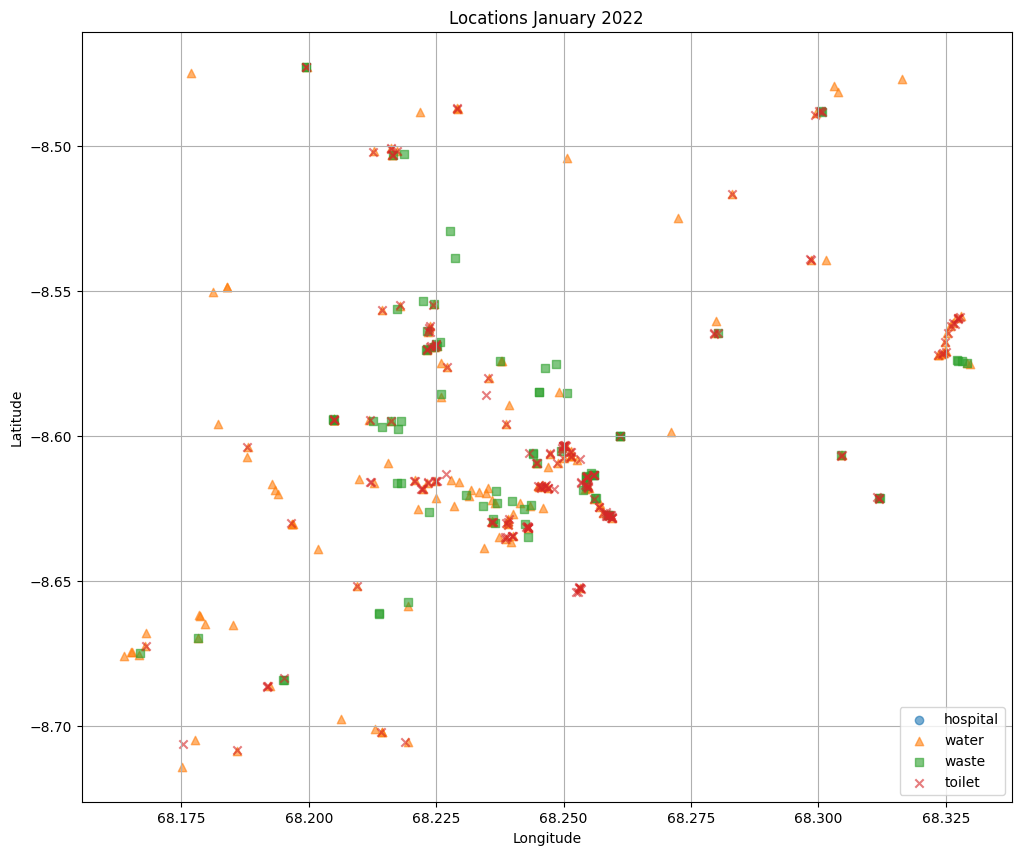

In [28]:
plot_locations()

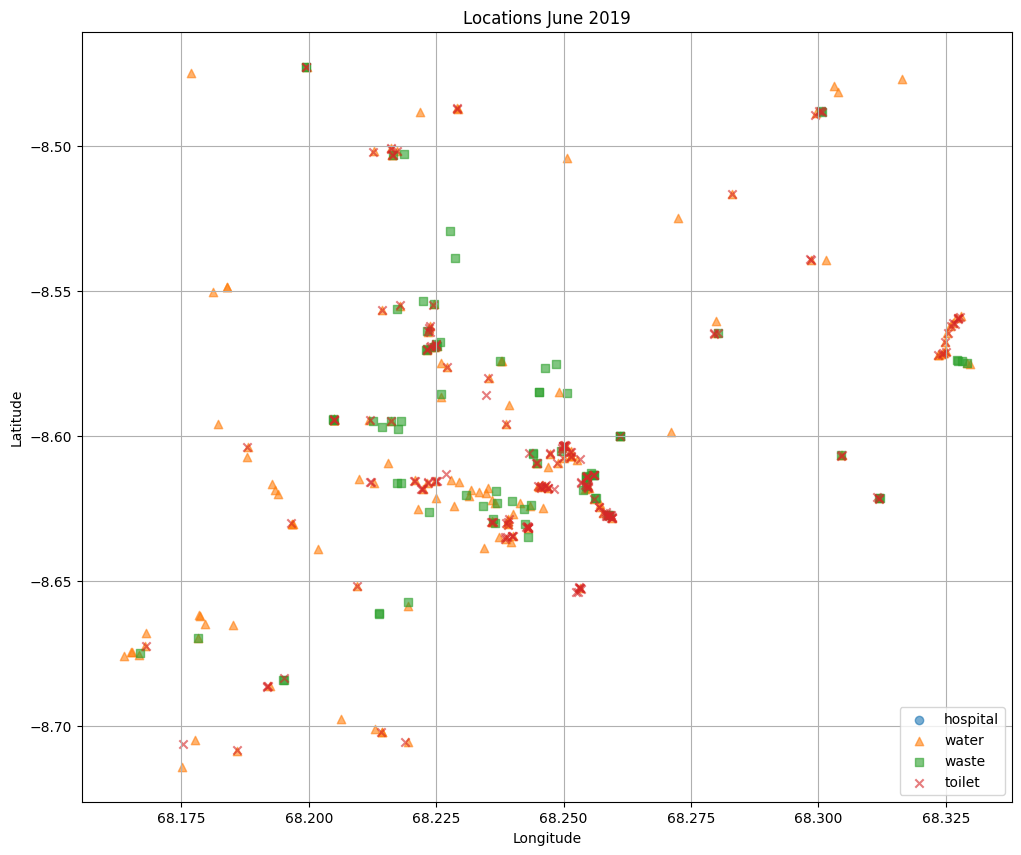

In [29]:
plot_locations(2019, 6)

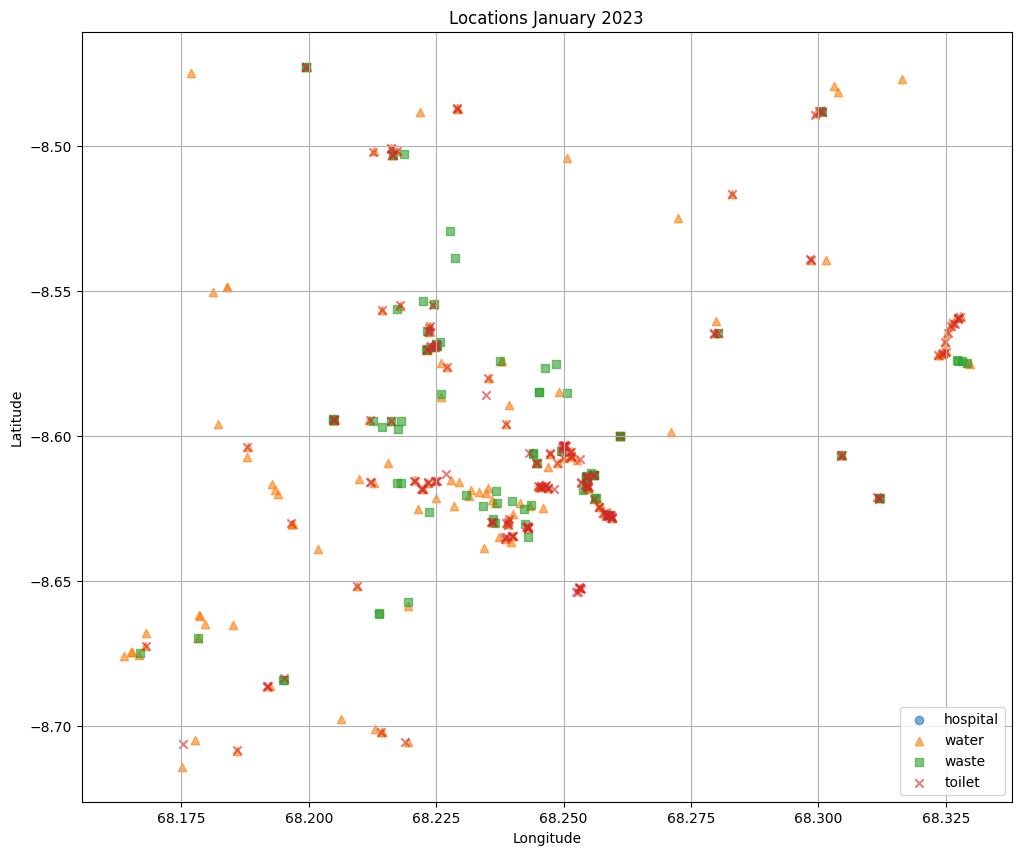

In [30]:
plot_locations(2023)

In [31]:
water.describe()

,water_Year,water_Month,water_10u,water_10v,water_2d,water_2t,water_evabs,water_evaow,water_evatc,water_evavt,...,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude
count,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,1.050000e+04,...,1.050000e+04,1.050000e+04,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000
mean,2021.000000,6.500000,-0.874489,0.149213,291.119261,296.321049,-0.001516,-0.000667,-0.000582,-1.666853e-05,...,1.716275e+07,2.990839e+07,-0.002782,0.003258,0.252771,0.264505,0.272055,0.297092,-8.600479,68.236903
std,1.414281,3.452217,0.468765,0.607776,2.464183,1.468999,0.000621,0.000288,0.000407,2.274614e-05,...,3.621966e+06,7.340210e+06,0.001130,0.003109,0.097806,0.087117,0.068872,0.047170,0.050385,0.040141
min,2019.000000,1.000000,-2.186940,-0.866400,286.144000,292.261000,-0.003307,-0.001376,-0.002149,-8.422280e-05,...,9.721450e+06,1.685050e+07,-0.004830,0.000176,0.109100,0.133270,0.146423,0.191055,-8.714190,68.163730
25%,2020.000000,3.750000,-1.218457,-0.417648,288.607000,295.137000,-0.002063,-0.000905,-0.000898,-3.710300e-05,...,1.390420e+07,1.864462e+07,-0.003749,0.000686,0.154800,0.182449,0.215332,0.261810,-8.626680,68.212920
50%,2021.000000,6.500000,-0.883673,0.183071,292.097500,296.453000,-0.001454,-0.000598,-0.000410,-3.352760e-08,...,1.759390e+07,3.339840e+07,-0.002601,0.002037,0.254257,0.264404,0.262787,0.296188,-8.609310,68.234660
75%,2022.000000,9.250000,-0.447104,0.663744,293.223000,297.417000,-0.001008,-0.000441,-0.000239,-1.909210e-08,...,2.002040e+07,3.543520e+07,-0.001814,0.005264,0.339630,0.338516,0.317383,0.321747,-8.570370,68.251460
max,2023.000000,12.000000,0.168609,1.355880,295.323000,299.871000,-0.000250,-0.000086,-0.000060,4.656610e-10,...,2.390000e+07,3.617010e+07,-0.000433,0.016407,0.415741,0.418869,0.420380,0.426147,-8.472700,68.329640


Merging the training and testing datasets

## Preparing Datasets for model training

In [32]:
merged_data = pd.concat([train, test])
merged_data.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267


In [33]:
def find_nearest(hospital_df, location_df, prefix):
    nearest = {}
    tree = cKDTree(location_df[[f"{prefix}_Transformed_Longitude", f"{prefix}_Transformed_Latitude"]].fillna(0).values)
    for _, row in hospital_df.iterrows():
        id = tree.query([row["Transformed_Longitude"], row["Transformed_Latitude"]])[1]
        nearest[row["ID"]] = location_df.iloc[id][f"{prefix}_Month_Year_lat_lon"]
    return nearest

In [34]:
datasets = [
    (water, "water"),
    (toilets, "toilet"),
    (waste, "waste")
]

In [35]:
for df, prefix in datasets:   
    nearest = find_nearest(merged_data, df, prefix)
    nearest_df = pd.DataFrame(nearest.items(), columns=["ID", f"{prefix}_Month_Year_lat_lon"])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=f"{prefix}_Month_Year_lat_lon")

In [36]:
merged_data.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,water_Month_Year_lat_lon,...,waste_e,waste_tp,waste_swvl1,waste_swvl2,waste_swvl3,waste_swvl4,waste_Transformed_Latitude,waste_Transformed_Longitude,waste_Month_Year,waste_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,12_2023_-8.62966_68.23589,...,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.62861,68.23612,5_2019,-8.62861_68.23612
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,12_2023_-8.62966_68.23589,...,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.62861,68.23612,5_2019,-8.62861_68.23612
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,12_2023_-8.62966_68.23589,...,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.62861,68.23612,5_2019,-8.62861_68.23612
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,12_2023_-8.62966_68.23589,...,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.62861,68.23612,5_2019,-8.62861_68.23612
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,12_2023_-8.62966_68.23589,...,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.62861,68.23612,5_2019,-8.62861_68.23612


Getting rid of useless columns in the dataset to improve performance of the model

In [37]:
previous = (merged_data.shape[1])
merged_data.drop(columns=[x for x in merged_data.columns if "lat_lon" in x or "_Year" in x or "_Month" in x or "_Transformed" in x], inplace=True) 
print(f"The number of columns before dropping is {previous} and after dropping is {merged_data.shape[1]}")
print(f"{previous - merged_data.shape[1]} columns have been dropped")

The number of columns before dropping is 138 and after dropping is 117
21 columns have been dropped


## Data Preprocessing and Model Creation

In [38]:
merge_train = merged_data[merged_data["Total"].notna()]
merge_test = merged_data[merged_data["Total"].isna()].drop(columns=["Total"])
test_id = merge_test["ID"]
merge_train.drop(columns=["ID"], inplace=True)
merge_test.drop(columns=["ID"], inplace=True)


In [39]:
train_object_dtype = merge_train.select_dtypes("object").count()
test_object_dtype = merge_test.select_dtypes("object").count()
print(f"The object columns in the train set are {train_object_dtype.index}")
print(f"The object columns in the test set are {test_object_dtype.index}")

The object columns in the train set are Index(['Location', 'Category_Health_Facility_UUID', 'Disease'], dtype='object')
The object columns in the test set are Index(['Location', 'Category_Health_Facility_UUID', 'Disease'], dtype='object')


There are three columns that are neaded to be converted to numerical values

In [40]:
for column in train_object_dtype.index:
    print(f"The number of unique values in {column} is {merge_train[column].nunique()}")

The number of unique values in Location is 57
The number of unique values in Category_Health_Facility_UUID is 4
The number of unique values in Disease is 7


In [41]:
for column in test_object_dtype.index:
    print(f"The number of unique values in {column} is {merge_test[column].nunique()}")

The number of unique values in Location is 58
The number of unique values in Category_Health_Facility_UUID is 170
The number of unique values in Disease is 7


The number of unique values of `Category_Health_Facility_UUID` in the test is vastly more than in the train.

Training with encoded values of that column may show some bad performance when testing the model. Therefore that column would be dropped from both the train and test set.

The presence of more facilities and locations can be due to the fact that the test set is from a later date than the train set.

In [42]:
merge_train.drop(columns="Category_Health_Facility_UUID", inplace=True)
merge_test.drop(columns="Category_Health_Facility_UUID", inplace=True)

Locations in the datasets are also different therefore it would be dropped

In [43]:
merge_train.drop(columns="Location", inplace=True)
merge_test.drop(columns="Location", inplace=True)

### One Hot Encoding

In [44]:
from sklearn.preprocessing import OneHotEncoder
hot_train = merge_train.copy()
hot_test = merge_test.copy()
for column in merge_train.select_dtypes("object").columns:
    one = OneHotEncoder()
    encoded_train = one.fit_transform(hot_train[column].values.reshape(-1,1)).toarray()
    encoded_train = pd.DataFrame(encoded_train, columns=one.get_feature_names_out())
    hot_train = pd.concat([hot_train, encoded_train], axis=1).drop(columns=column)

for column in merge_test.select_dtypes("object").columns:
    one = OneHotEncoder()
    encoded_test = one.fit_transform(hot_test[column].values.reshape(-1,1)).toarray()
    encoded_test = pd.DataFrame(encoded_test, columns=one.get_feature_names_out(), index=hot_test.index)
    hot_test = pd.concat([hot_test, encoded_test], axis=1).drop(columns=column)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
hot_x = hot_train.drop(columns="Total")
hot_y = hot_train["Total"]
hot_X_train, hot_X_val, hot_y_train, hot_y_val = train_test_split(hot_x, hot_y, test_size=0.2, random_state=SEED)

### Model building

#### Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [48]:
forest_model = RandomForestRegressor(random_state=SEED)
forest_model.fit(hot_X_train, hot_y_train)

RandomForestRegressor(random_state=42)

In [49]:
y_val_pred = forest_model.predict(hot_X_val).round()
forest_hot_acc = mean_absolute_error(hot_y_val, y_val_pred)


In [50]:
forest_acc = pd.DataFrame({"MAE": [forest_hot_acc]}, index=["Random Forest Regressor"])

#### Lasso Regression

In [51]:
from sklearn.linear_model import Lasso

In [52]:
lasso_model = Lasso(random_state=SEED)
lasso_model.fit(hot_X_train, hot_y_train)

Lasso(random_state=42)

In [53]:
y_val_pred = lasso_model.predict(hot_X_val).round()
lasso_hot_acc = mean_absolute_error(hot_y_val, y_val_pred)

In [54]:
lasso_acc = pd.DataFrame({"MAE": [lasso_hot_acc]}, index=["Lasso Regression"])

#### Ridge Regression

In [55]:
from sklearn.linear_model import Ridge

In [56]:
ridge_model = Ridge(random_state=SEED)
ridge_model.fit(hot_X_train, hot_y_train)

Ridge(random_state=42)

In [57]:
y_val_pred = ridge_model.predict(hot_X_val).round()
ridge_hot_acc = mean_absolute_error(hot_y_val, y_val_pred)

In [58]:
ridge_acc = pd.DataFrame({"MAE": [ridge_hot_acc]}, index=["Ridge Regression"])

In [59]:
MAE = pd.concat([lasso_acc, ridge_acc])
MAE = pd.concat([MAE, forest_acc])
MAE

,MAE
Lasso Regression,12.335010
Ridge Regression,11.868344
Random Forest Regressor,11.105451


The `Random Forest Regressor` has the better `MAE` score than the other two models.


### Hyperparameter tuning

In [60]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [50, 100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5]
# }

# grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED), param_grid=param_grid, cv=5)
# grid_search.fit(hot_X_train, hot_y_train)

In [61]:
# grid_search.best_params_

In [62]:
# grid_search.best_score_

In [63]:
# grid_pred = grid_search.predict(hot_X_val).round()
# print(mean_absolute_error(hot_y_val, grid_pred))

### Model with best hyperparameters

In [64]:
model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5, random_state=SEED)
model.fit(hot_X_train, hot_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=300,
                      random_state=42)

In [65]:
y_pred_val = model.predict(hot_X_val).round()
hype_forest_acc = mean_absolute_error(hot_y_val, y_pred_val)

In [66]:
hype_forest_acc = pd.DataFrame({"MAE": hype_forest_acc}, index=["Tuned Random Forest Regressor"])
MAE = pd.concat([MAE, hype_forest_acc])

In [67]:
MAE

,MAE
Lasso Regression,12.335010
Ridge Regression,11.868344
Random Forest Regressor,11.105451
Tuned Random Forest Regressor,9.779665


#### Feature importance

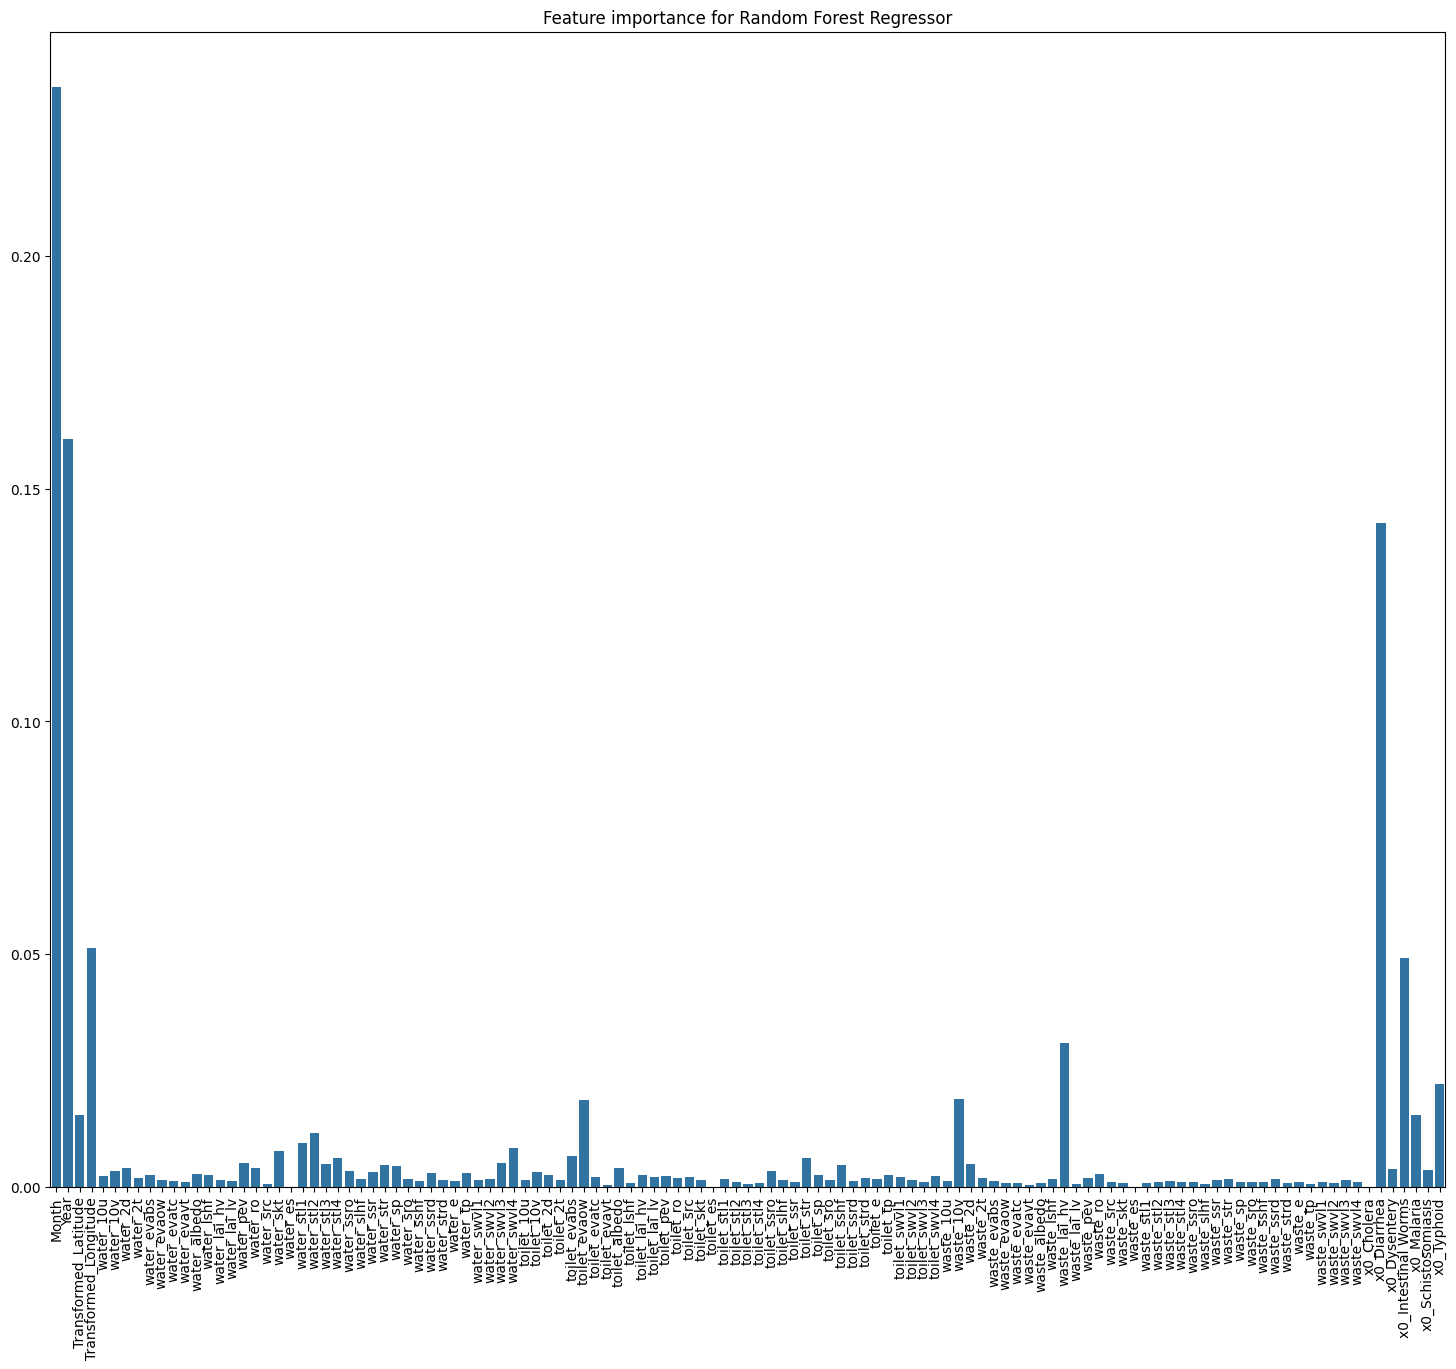

In [68]:
plt.figure(figsize=(18, 15))
sns.barplot(x=model.feature_names_in_, y=model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance for Random Forest Regressor")
plt.show()


In [69]:
feature_importance = pd.DataFrame({"Features": model.feature_names_in_, "Importances": model.feature_importances_})
feature_importance

,Features,Importances
0,Month,0.236412
1,Year,0.160759
2,Transformed_Latitude,0.015282
3,Transformed_Longitude,0.051315
4,water_10u,0.002354
...,...,...
114,x0_Dysentery,0.003733
115,x0_Intestinal Worms,0.049096
116,x0_Malaria,0.015278
117,x0_Schistosomiasis,0.003545


### Feature Selection

In [70]:
feature_importance.describe().T

,count,mean,std,min,25%,50%,75%,max
Importances,119.0,0.008403,0.029443,0.0,0.001014,0.001704,0.003485,0.236412


In [71]:
feature_importance.query("Importances == 0")

,Features,Importances
20,water_es,0.0
56,toilet_es,0.0
92,waste_es,0.0


In [72]:
feature_importance.tail(7)

,Features,Importances
112,x0_Cholera,4.372179e-08
113,x0_Diarrhea,1.426981e-01
114,x0_Dysentery,3.732951e-03
115,x0_Intestinal Worms,4.909606e-02
116,x0_Malaria,1.527798e-02
117,x0_Schistosomiasis,3.544643e-03
118,x0_Typhoid,2.211416e-02


The feature importances of `water_es`, `toilet_es` and `waste_es` are `0` so they can be removed from the dataset to reduce complexity

In [73]:
hot_train.drop(columns=["toilet_es", "waste_es", "water_es"], inplace=True)
hot_test.drop(columns=["toilet_es", "waste_es", "water_es"], inplace=True)

In [74]:
feature_importance = feature_importance.query("Features not in ['waste_es', 'toilet_es', 'water_es']")

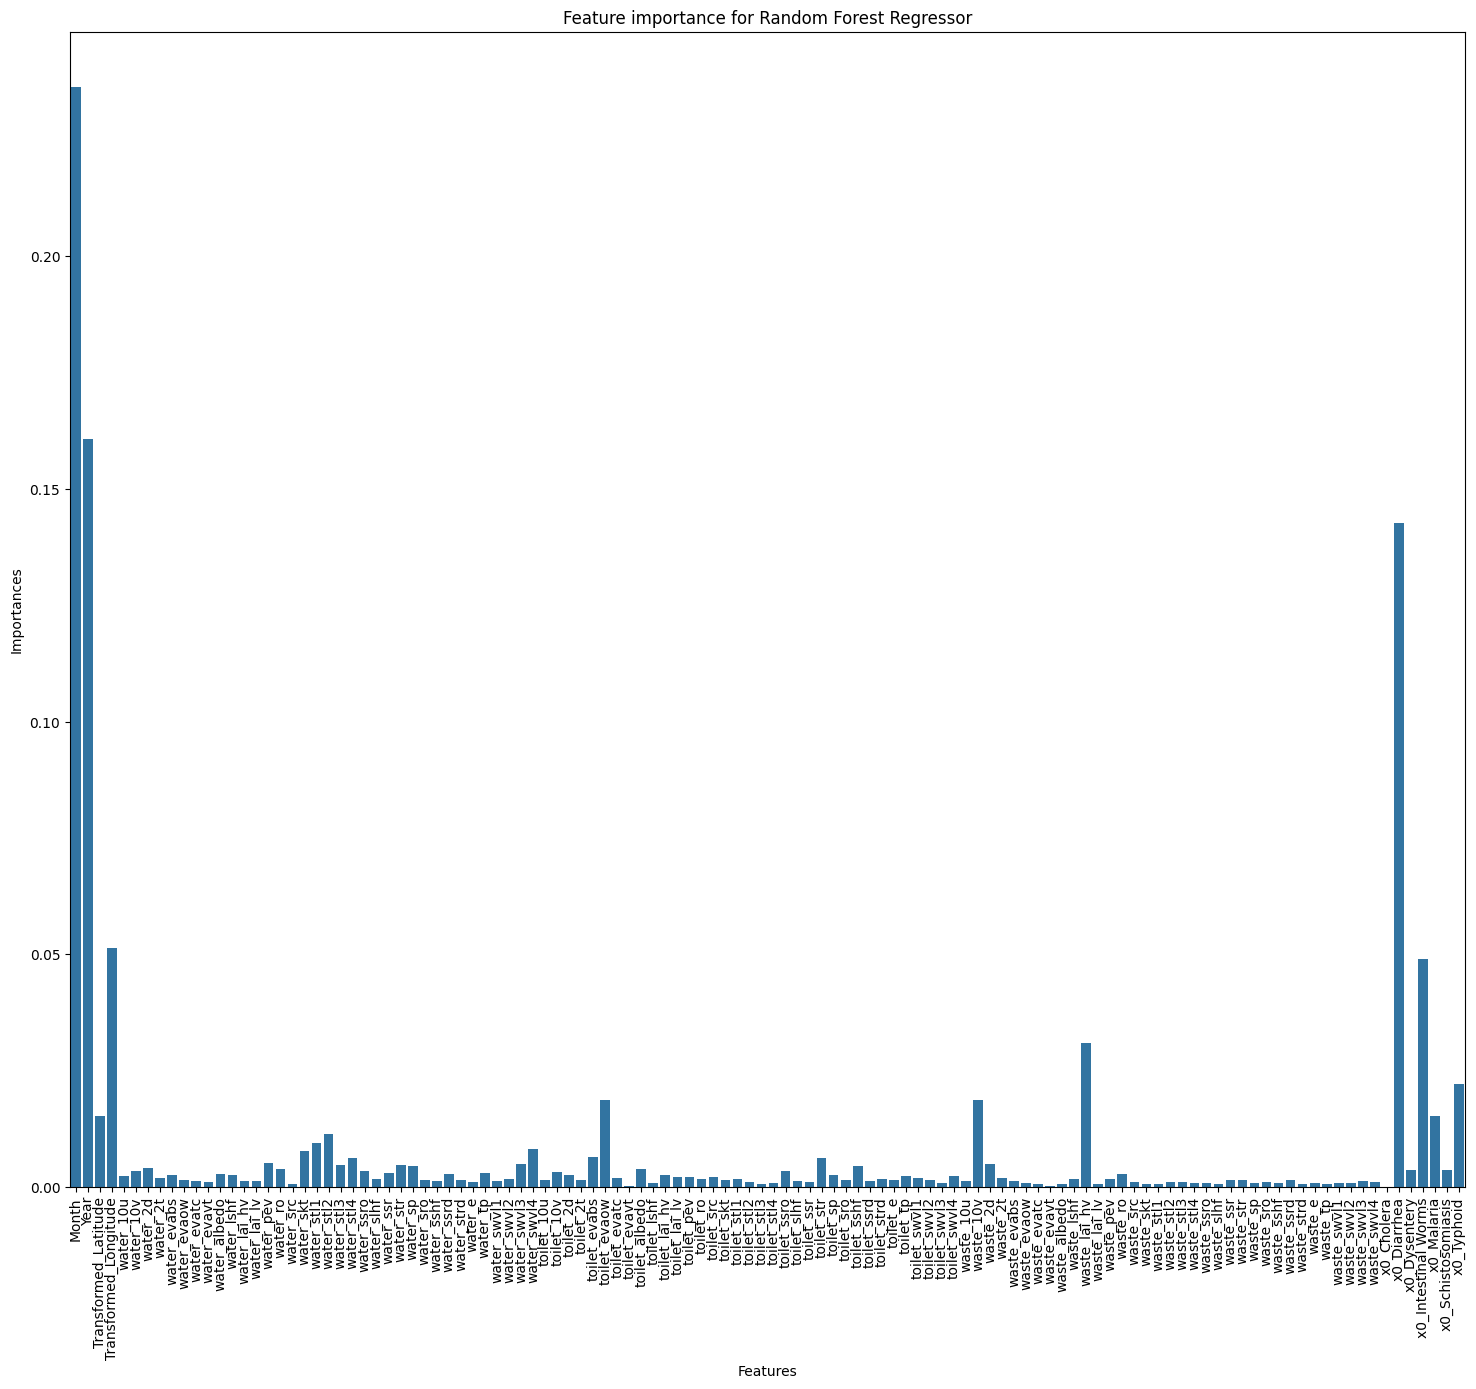

In [75]:
plt.figure(figsize=(18, 15))
sns.barplot(x=feature_importance["Features"], y=feature_importance["Importances"])
plt.xticks(rotation=90)
plt.title("Feature importance for Random Forest Regressor")
plt.show()


In [76]:
hot_x = hot_train.drop(columns="Total")
hot_y = hot_train["Total"]
hot_X_train, hot_X_val, hot_y_train, hot_y_val = train_test_split(hot_x, hot_y, test_size=0.2, random_state=SEED)

In [77]:
model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5, random_state=SEED)
model.fit(hot_X_train, hot_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=300,
                      random_state=42)

In [78]:
y_pred_val = model.predict(hot_X_val)
hype_forest_acc = mean_absolute_error(hot_y_val, y_pred_val)

In [79]:
hype_forest_acc = pd.DataFrame({"MAE": hype_forest_acc}, index=["Extracted Random Forest Regressor"])
MAE = pd.concat([MAE, hype_forest_acc])

In [80]:
MAE

,MAE
Lasso Regression,12.335010
Ridge Regression,11.868344
Random Forest Regressor,11.105451
Tuned Random Forest Regressor,9.779665
Extracted Random Forest Regressor,9.775739


In [81]:
feature_importance_percentage = pd.DataFrame({"Features": model.feature_names_in_, "Importances": (model.feature_importances_/sum(model.feature_importances_))*100})
feature_importance_percentage

,Features,Importances
0,Month,23.635079
1,Year,16.081125
2,Transformed_Latitude,1.551218
3,Transformed_Longitude,5.125577
4,water_10u,0.247572
...,...,...
111,x0_Dysentery,0.371993
112,x0_Intestinal Worms,4.907105
113,x0_Malaria,1.538193
114,x0_Schistosomiasis,0.345775


In [82]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
gradient_model = GradientBoostingRegressor()
gradient_model.fit(hot_X_train, hot_y_train)
y_pred_val = gradient_model.predict(hot_X_val)
hype_gradient_acc = mean_absolute_error(hot_y_val, y_pred_val)
hype_gradient_acc = pd.DataFrame({"MAE": hype_gradient_acc}, index=["Gradient Boosting Regressor"])
MAE = pd.concat([MAE, hype_gradient_acc])
MAE

,MAE
Lasso Regression,12.335010
Ridge Regression,11.868344
Random Forest Regressor,11.105451
Tuned Random Forest Regressor,9.779665
Extracted Random Forest Regressor,9.775739
Gradient Boosting Regressor,10.242217


In [84]:
# merge_train.columns

In [85]:
# def draw_corr(df, name):
#     plt.figure(figsize=(20, 20))
#     corr = df.select_dtypes("number").drop(columns=["Month", "Year", "Transformed_Latitude", "Transformed_Longitude"])[[x for x in df.columns if name in x]].corr()
#     sns.heatmap(corr, annot=True, cmap="coolwarm")
#     plt.title(f"Heatmap of correlation of all {name} features")
#     plt.show()

# draw_corr(merge_train, "water")
# draw_corr(merge_train, "toilet")
# draw_corr(merge_train, "waste")

Some features in the correlation graphs are have a high correlation. To reduce complexity and overfitting, we can remove some of these features.

In [86]:
# def remove_corr(df:pd.DataFrame, name):
#     copy = df[[x for x in df.columns if name in x]]
#     count = 0
#     removed = []
#     for i in range(copy.shape[1]):
#         one = copy.iloc[:, i]
#         for j in range(i+1, copy.shape[1]):
#             two = copy.iloc[:, j]
#             corr = pd.concat([one, two], axis=1).corr()
#             if (corr[round(corr, 2) >= 0.99].count() == 2)[0]:
#                 if not two.name in removed:
#                     df.drop(columns=two.name, inplace=True)
#                     removed.append(two.name)
#                     count += 1
#     print(f"Number of columns removed: {count}")
#     return removed
# water_removed = remove_corr(hot_train, "water")
# toilet_removed = remove_corr(hot_train, "toilet")
# waste_removed = remove_corr(hot_train, "waste")


In [87]:
# removed = water_removed + toilet_removed + waste_removed

In [88]:
# draw_corr(hot_train, "water")
# draw_corr(hot_train, "waste")
# draw_corr(hot_train, "toilet")


In [89]:
# hot_x = hot_train.drop(columns="Total")
# hot_y = hot_train["Total"]
# hot_X_train, hot_X_val, hot_y_train, hot_y_val = train_test_split(hot_x, hot_y, test_size=0.2, random_state=SEED)

In [90]:
# forest_model = RandomForestRegressor(random_state=SEED)
# forest_model.fit(hot_X_train, hot_y_train)

In [91]:
# y_val_pred = forest_model.predict(hot_X_val).round()
# forest_hot_acc = mean_absolute_error(hot_y_val, y_val_pred)
# forest_hot_acc

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5, random_state=SEED)
k_folds = KFold(n_splits=5, random_state=SEED, shuffle=True)
scores = cross_val_score(model, hot_train.drop(columns="Total"), hot_train["Total"], cv=k_folds, scoring="neg_mean_absolute_error")

InvalidParameterError: The 'scoring' parameter of cross_val_score must be a str among {'jaccard', 'jaccard_samples', 'recall_micro', 'neg_brier_score', 'matthews_corrcoef', 'adjusted_mutual_info_score', 'neg_mean_squared_log_error', 'jaccard_macro', 'mutual_info_score', 'neg_mean_gamma_deviance', 'roc_auc_ovr', 'd2_absolute_error_score', 'neg_log_loss', 'recall_macro', 'precision_weighted', 'neg_root_mean_squared_log_error', 'precision_micro', 'precision', 'homogeneity_score', 'recall', 'roc_auc_ovr_weighted', 'neg_mean_absolute_percentage_error', 'explained_variance', 'f1_micro', 'roc_auc_ovo_weighted', 'f1_macro', 'positive_likelihood_ratio', 'recall_weighted', 'neg_root_mean_squared_error', 'roc_auc', 'balanced_accuracy', 'average_precision', 'accuracy', 'neg_mean_squared_error', 'normalized_mutual_info_score', 'top_k_accuracy', 'rand_score', 'jaccard_micro', 'neg_negative_likelihood_ratio', 'jaccard_weighted', 'precision_samples', 'v_measure_score', 'f1_weighted', 'neg_median_absolute_error', 'precision_macro', 'f1_samples', 'r2', 'neg_mean_absolute_error', 'adjusted_rand_score', 'neg_mean_poisson_deviance', 'f1', 'max_error', 'recall_samples', 'roc_auc_ovo', 'completeness_score', 'fowlkes_mallows_score'}, a callable or None. Got 'abs_mean_absolute_error' instead.

In [104]:
print("The Cross validation Scores:" , scores)
print("The Mean of the Cross validation Scores:" , scores.mean())
print("Number of CV Scores used in average: " + str(len(scores)))

The Cross validation Scores: [-9.79776622 -9.81804571 -9.48011624 -9.50777547 -9.99103746]
The Mean of the Cross validation Scores: -9.718948220543712
Number of CV Scores used in average: 5


### Full set training

Now training the model with the full training set for model building

In [92]:
final_x = hot_train.drop(columns="Total")
final_y = hot_train["Total"]
forest_model = RandomForestRegressor(random_state=SEED)
forest_model.fit(final_x, final_y)

RandomForestRegressor(random_state=42)

In [93]:
y_pred_forest = forest_model.predict(hot_test)

In [94]:
submission = {"ID":test_id, "Total": y_pred_forest}
submission = pd.DataFrame(submission)
submission.to_csv("submission.csv", index=False)